# Deep Learning Image Registration (DLIR) Framework
## An example on MNIST

TorchIR is a image registration library for **deep learning image registration (DLIR)**. I have 
integrated several ideas for image registration.

I rely on PyTorch Lightning, which can be installed via:
> pip install pytorch-lightning

The pytorch-lightning trainer modules automatically create tensorboard log files. I store them in 
the `./output/lightning_logs` directory. Simply inspect them using:
> tensorboard --logdir=./output/lightning_logs

If you use this code for your publications, don't forget to cite my work ;)

[1] Bob D. de Vos, Floris F. Berendsen, Max A. Viergever, Marius Staring and Ivana Išgum, 
"End-to-end unsupervised deformable image registration with a convolutional neural network," 
in Deep learning in medical image analysis and multimodal learning for clinical decision support. 
Springer, Cham, 2017. p. 204-212, doi: 10.1007/978-3-319-67558-9_24
https://link.springer.com/chapter/10.1007%2F978-3-319-67558-9_24

[2] Bob D. de Vos, Floris F. Berendsen, Max A. Viergever, Hessam Sokooti, Marius Staring and Ivana Išgum
"A deep learning framework for unsupervised affine and deformable image registration," Medical image analysis, vol. 52, pp. 128-143, Feb. 2019, doi: 10.1016/j.media.2018.11.010
https://www.sciencedirect.com/science/article/pii/S1361841518300495

Please note that the code is still under heavy development and I'd really love your input.

In [51]:
%load_ext autoreload

%autoreload 2
    
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
DEST_DIR = Path('./output')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The data
To illustrate the workings of the code I'll set up a registration experiment using MNIST data. I also used these in my first publication on deep learning image registration [1]. We will setup the experiments such that only one number will be loaded and we will register those to eachother.

We'll start with loading some modules

In [52]:
import numpy as np
import torch
from torchvision import transforms
from torchvision.datasets import MNIST
from torchir.utils import IRDataSet

Then we create a specific dataset class that selects MNIST instances with a specific class label. Here we take all number 9s.

In [53]:
class MNISTSubSet(MNIST):
    '''
    A Dataset class that selects a single type of MNIST digit.
    '''
    def __init__(self, label, rng=np.random.default_rng(), *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert(label >= 0 and label <= 9)
        idcs = torch.where(self.targets == label)
        
        self.data = self.data[idcs]
        self.targets = self.targets[idcs]

        self.transform = transform
        self.rng = rng
        
    def __getitem__(self, idx):
        return super().__getitem__(idx)[0] # only return image

        

Next we set up the dataloaders.

In [54]:
rng = np.random.default_rng(808)
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5), (0.5)),
                             ])
ds_train_subset = MNISTSubSet(label=9, rng=rng, root='../datasets/',  transform=transform, download=True, train=True)

We reserve part of the training set for validation. Note that we only select a small number for validation. This will become clear immediately after this block.

In [56]:
val_set_size = 20
train_set_size = len(ds_train_subset) - val_set_size
ds_train_subset, ds_validation_subset = torch.utils.data.random_split(ds_train_subset, [train_set_size, val_set_size], 
                                                        generator=torch.Generator().manual_seed(808))
ds_test_subset = MNISTSubSet(label=9, rng=rng, root='../datasets/',  transform=transform, download=True, train=False)
print(f'Training subset size: {len(ds_train_subset)}')
print(f'Validation subset size: {len(ds_validation_subset)}')
print(f'Test subset size: {len(ds_test_subset)}')

Training subset size: 5929
Validation subset size: 20
Test subset size: 1009


Now we will employ a convenience class to convert the training and validation data sets into image registration sets. The new class will provide all possible permutations of the input dataset. Note that this will heavily increase the number of training instances (i.e. there are many fixed and moving image permutations). Note that we will use the test set later in a different manner.

In [57]:
ds_train = IRDataSet(ds_train_subset)
ds_validation = IRDataSet(ds_validation_subset)
print(f'Training IR set size: {len(ds_train)}')
print(f'Validation IR set size: {len(ds_validation)}')

Training IR set size: 35153041
Validation IR set size: 400


Note that each instance of an IR dataset is a permutation of a fixed and moving image. This results in a very high number of possible permutations. Since Pytorch Lightning does not play well with iterations and rather likes epochs, we limit the number of permutations per epoch by setting up our own data samplers:

In [58]:
batch_size = 32
training_batches = 100
validation_batches = 10

train_sampler = torch.utils.data.RandomSampler(ds_train, replacement=True, 
                                               num_samples=training_batches*batch_size, 
                                               generator=torch.Generator().manual_seed(808))
train_loader = torch.utils.data.DataLoader(ds_train, batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(ds_validation, batch_size)

We have setup all our data classes and now we can start the image registration experiments.

# Single DIRNet

We will first start with deformable image registration using a single layer of b-spline registration. For this, we will initialize a DIRNet model, which is a straight-forward network [1, 2]. The DIRNet takes two images, a fixed and moving image, as its input and it outputs a number of control points: output shape is: num_samples, ndim=2, image_height//grid_spacing, image_width//grid_spacing. 

The DIRNet is initialized with a grid spacing of (8, 8) voxels. The network can handle a varying input of image sizes, because the network is implemented in a fully convolutional way. The order of the b-spline is set at 3 (i.e. cubic), which is common for Bspline registration.

We use the model to initialize a BsplineTransformer layer. The BsplineTransformer is tasked with interpolating the b-spline control points to a full displacement vector field (DVF). For convenience, the BsplineTransformer will automatically resample the moving image, using the generated DVF.

To simplify the code, I have used pytorch-lighting. Pytorch lighthning can easily be installed via `pip install pytorch-lighting`

Pytorch lightning may look a bit daunting if you're not used to it, but I am sure you'll learn to appreciate it when you notice how it nicely procedures things such as logging and pushing data to the GPU.

In [55]:
import pytorch_lightning as pl
from torchir.networks import DIRNet
from torchir.metrics import NCC
from torchir.transformers import BsplineTransformer

In [62]:
class LitDIRNet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        grid_spacing = (8, 8)
        self.dirnet = DIRNet(kernels=16, grid_spacing=grid_spacing)
        self.bspline_transformer = BsplineTransformer(ndim=2, upsampling_factors=grid_spacing)
        self.metric = NCC()
    
    def configure_optimizers(self):
        lr = 0.001
        optimizer = torch.optim.Adam(self.dirnet.parameters(), lr=lr, amsgrad=True)
        return optimizer

    def forward(self, fixed, moving):
        params = self.dirnet(fixed, moving)
        warped = self.bspline_transformer(params, fixed, moving)
        return warped
    
    def training_step(self, batch, batch_idx):
        warped = self(batch['fixed'], batch['moving'])
        loss = self.metric(batch['fixed'], warped)
        self.log('NCC/training', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        warped = self(batch['fixed'], batch['moving'])
        loss = self.metric(batch['fixed'], warped)
        self.log('NCC/validation', loss)
        return loss  

Now we set up the trainer and start training.

In [63]:
model = LitDIRNet()
trainer = pl.Trainer(default_root_dir=DEST_DIR, 
                     log_every_n_steps=50,
                     val_check_interval=50, 
                     max_epochs=100, 
                     gpus=1)
trainer.fit(model, train_loader, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | dirnet              | DIRNet             | 10.2 K
1 | bspline_transformer | BsplineTransformer | 1.0 K 
2 | metric              | NCC                | 0     
-----------------------------------------------------------
10.2 K    Trainable params
1.0 K     Non-trainable params
11.2 K    Total params
0.045     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

We save the network:

In [ ]:
trainer.save_checkpoint(DEST_DIR / 'mnist_ir_8.ckpt')

To illustrate its performance, we recreate an experiment from my paper [1] where we take one fixed image from the test set and register all other images to that target image.

In [ ]:
avg_moving = np.zeros((28, 28), dtype=float)
avg_warped = np.zeros((28, 28), dtype=float)
model = model.cuda()
model.eval()
fixed = ds_test_subset[0]
with torch.no_grad():
    for moving in tqdm(ds_test_subset):
        warped = model(fixed[None].cuda(), moving[None].cuda()).detach().squeeze().cpu().numpy()
        avg_moving += moving.squeeze().cpu().numpy() / len(ds_test_subset)
        avg_warped += warped / len(ds_test_subset)

In [ ]:
fig, axarr = plt.subplots(1, 3, figsize=(10, 3.5))
axarr[0].imshow(-fixed.squeeze().cpu().numpy(), cmap='gray', vmin=-1, vmax=1)
axarr[1].imshow(-avg_moving, cmap='gray', vmin=-1, vmax=1)
axarr[2].imshow(-avg_warped, cmap='gray', vmin=-1, vmax=1)
for ax in axarr.ravel():
    ax.axis('off')

axarr[0].set_title('fixed image')
axarr[1].set_title('images before registration')
axarr[2].set_title('images after registration')

fig.suptitle('Deformable image registration network (DIRNet)');

If you want to inspect the data, use tensorboard. The logs are stored in the specified `DEST_DIR`.

# Affine registration

We can also do affine registration, which I showed in [2].
Note that with the data we use here, the fixed and moving batches are of similar size, but, as demonstrated in the paper, they can be of different size. The AIRNet allows this.

In [59]:
from torchir.networks import AIRNet
from torchir.transformers import AffineTransformer

In [60]:
class LitAIRNet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.airnet = AIRNet(kernels=16)
        self.global_transformer = AffineTransformer(ndim=2)
        self.metric = NCC()
    
    def configure_optimizers(self):
        lr = 0.001
        optimizer = torch.optim.Adam(self.airnet.parameters(), lr=lr, amsgrad=True)
        return optimizer

    def forward(self, fixed, moving):
        parameters = self.airnet(fixed, moving)
        warped  = self.global_transformer(parameters, fixed, moving)
        return warped
    
    def training_step(self, batch, batch_idx):
        warped = self(batch['fixed'], batch['moving'])
        loss = self.metric(batch['fixed'], warped)
        self.log('NCC/training', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        warped = self(batch['fixed'], batch['moving'])
        loss = self.metric(batch['fixed'], warped)
        self.log('NCC/validation', loss)
        return loss  

In [61]:
model = LitAIRNet()
trainer = pl.Trainer(default_root_dir=DEST_DIR,
                     log_every_n_steps=50,
                     val_check_interval=50,
                     max_epochs=100,
                     gpus=1)
trainer.fit(model, train_loader, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type              | Params
---------------------------------------------------------
0 | airnet             | AIRNet            | 16.2 K
1 | global_transformer | AffineTransformer | 0     
2 | metric             | NCC               | 0     
---------------------------------------------------------
16.2 K    Trainable params
0         Non-trainable params
16.2 K    Total params
0.065     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\Users\Bob\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Bob\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

C:\Users\Bob\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


We save the network:

In [ ]:
trainer.save_checkpoint(DEST_DIR / 'mnist_ir_affine.ckpt')

Now we check if it can register images:

In [ ]:
avg_moving = np.zeros((28, 28), dtype=float)
avg_warped = np.zeros((28, 28), dtype=float)
model = model.cuda()
fixed = ds_test_subset[0]
for moving in tqdm(ds_test_subset):
    warped = model(fixed[None].cuda(), moving[None].cuda()).detach().squeeze().cpu().numpy()
    avg_moving += moving.squeeze().cpu().numpy() / len(ds_test_subset)
    avg_warped += warped / len(ds_test_subset)

In [ ]:
fig, axarr = plt.subplots(1, 3, figsize=(10, 3.5))
axarr[0].imshow(-fixed.squeeze().cpu().numpy(), cmap='gray', vmin=-1, vmax=1)
axarr[1].imshow(-avg_moving, cmap='gray', vmin=-1, vmax=1)
axarr[2].imshow(-avg_warped, cmap='gray', vmin=-1, vmax=1)
for ax in axarr.ravel():
    ax.axis('off')

axarr[0].set_title('fixed image')
axarr[1].set_title('images before registration')
axarr[2].set_title('images after registration')

fig.suptitle('Affine image registration network (AIRNet)');

# DLIR Framework

In [2] I also demonstrated that multiple coarse-to-fine registration layers improve image registration. Now let's implement this using the DLIRFramework module. I chose a dynamic implementation where we add a layer. We train the layer. We add another layer and fix the weight of the previous layer. We train the new layer. Etc...

In [64]:
from torchir.dlir_framework import DLIRFramework

In [65]:
class LitDLIRFramework(pl.LightningModule):
    def __init__(self, only_last_trainable=True):
        super().__init__()
        self.dlir_framework = DLIRFramework(only_last_trainable=only_last_trainable)
        self.add_stage = self.dlir_framework.add_stage
        self.metric = NCC()
    
    def configure_optimizers(self):
        lr = 0.001
        weight_decay = 0
        optimizer = torch.optim.Adam(self.dlir_framework.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=True)
        return {'optimizer': optimizer}

    def forward(self, fixed, moving):
        warped = self.dlir_framework(fixed, moving)
        return warped
    
    def training_step(self, batch, batch_idx):
        warped = self(batch['fixed'], batch['moving'])
        loss = self.metric(batch['fixed'], warped)
        self.log('NCC/training', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        warped = self(batch['fixed'], batch['moving'])
        loss = self.metric(batch['fixed'], warped)
        self.log('NCC/validation', loss)
        return loss  

Initialize the model, and add an affine registration layer:

In [71]:
model = LitDLIRFramework(only_last_trainable=False)
model.add_stage(network=AIRNet(kernels=16), transformer=AffineTransformer(ndim=2))
# trainer = pl.Trainer(default_root_dir=DEST_DIR,
#                      log_every_n_steps=50,
#                      val_check_interval=50,
#                      max_epochs=100,
#                      gpus=1)
# trainer.fit(model, train_loader, val_loader)

Add a BSpline layer with an 8x8 grid:

In [72]:
model.add_stage(network=DIRNet(ndim=2, grid_spacing=(8, 8), kernels=16, num_conv_layers=5, num_dense_layers=2),
                transformer=BsplineTransformer(ndim=2, upsampling_factors=(8, 8)))
# trainer = pl.Trainer(default_root_dir=DEST_DIR,
#                      log_every_n_steps=50,
#                      val_check_interval=50,
#                      max_epochs=100,
#                      gpus=1)
# trainer.fit(model, train_loader, val_loader)

Add a finer 4x4 grid and train.

In [73]:
model.add_stage(network=DIRNet(grid_spacing=(4, 4), kernels=16, num_conv_layers=5, num_dense_layers=2),
                transformer=BsplineTransformer(ndim=2, upsampling_factors=(4, 4)))
trainer = pl.Trainer(default_root_dir=DEST_DIR,
                     log_every_n_steps=50,
                     val_check_interval=50,
                     max_epochs=100,
                     gpus=1)
trainer.fit(model, train_loader, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params
-------------------------------------------------
0 | dlir_framework | DLIRFramework | 37.8 K
1 | metric         | NCC           | 0     
-------------------------------------------------
36.5 K    Trainable params
1.3 K     Non-trainable params
37.8 K    Total params
0.151     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Let's store the checkpoint

In [ ]:
trainer.save_checkpoint(DEST_DIR / 'mnist_dlir_affine_8_4.ckpt')

Now do ultra-fast coarse-to-fine image registration:

In [74]:
avg_moving = np.zeros((28, 28), dtype=float)
avg_warped = np.zeros((28, 28), dtype=float)
model = model.cuda()
fixed = ds_test_subset[0]
for moving in tqdm(ds_test_subset):
    warped = model(fixed[None].cuda(), moving[None].cuda()).detach().squeeze().cpu().numpy()
    avg_moving += moving.squeeze().cpu().numpy() / len(ds_test_subset)
    avg_warped += warped / len(ds_test_subset)

  0%|          | 0/1009 [00:00<?, ?it/s]

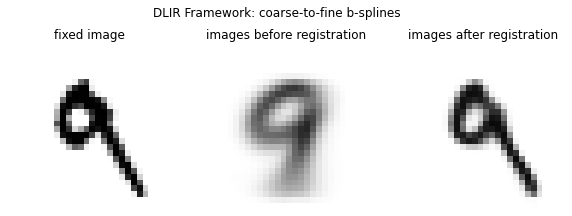

In [75]:
fig, axarr = plt.subplots(1, 3, figsize=(10, 3.5))

axarr[0].imshow(-fixed.squeeze().cpu().numpy(), cmap='gray', vmin=-1, vmax=1)
axarr[1].imshow(-avg_moving, cmap='gray', vmin=-1, vmax=1)
axarr[2].imshow(-avg_warped, cmap='gray', vmin=-1, vmax=1)

for ax in axarr.ravel():
    ax.axis('off')

axarr[0].set_title('fixed image')
axarr[1].set_title('images before registration')
axarr[2].set_title('images after registration')

fig.suptitle('DLIR Framework: coarse-to-fine b-splines');

# Loading a model

Loading a model for later use can be done as follows:

In [ ]:
model = LitDLIRFramework()
model.add_stage(GlobalTransformer(AIRNet(kernels=16)))
model.add_stage(BsplineTransformer(DIRNet(grid_spacing=(8, 8), kernels=16, num_conv_layers=5, num_dense_layers=2)))
model.add_stage(BsplineTransformer(DIRNet(grid_spacing=(4, 4), kernels=16, num_conv_layers=5, num_dense_layers=2)))
model.load_state_dict(torch.load(DEST_DIR / 'mnist_dlir_affine_8_4.ckpt')['state_dict'])

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from torchir.transformers import AffineTransformer

In [4]:
import torch


In [5]:
from skimage import data

In [6]:
x = torch.tensor(data.astronaut(), dtype=torch.float32)/255

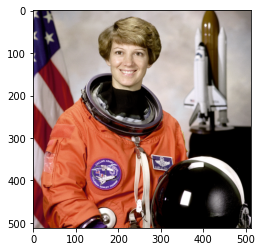

In [7]:
plt.imshow(x)


In [8]:
T = AffineTransformer(ndim=2, coord_dim=1)

In [9]:
x = x.movedim(2,0)[None];

In [10]:
x.shape

torch.Size([1, 3, 512, 512])

In [47]:
shear = torch.zeros((1,2))
t = torch.zeros((1,2))
r = torch.zeros((1,1))
s = torch.ones((1,2))
r = torch.ones((1,1)) * .25 * 3.14

In [48]:
T.ndim

2

In [49]:
y = T.forward((t, r, s, shear), x, x)

tensor([[-256., -256.]]) tensor([[-256., -256.]])


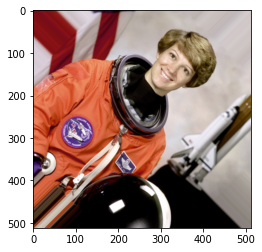

In [50]:
plt.imshow(y.squeeze().movedim(0,-1))

In [14]:
torch.tensor(x.shape[2:],
             dtype=torch.float32,
             device=x.device,
            )[None] / 2.

tensor([[256., 256.]])

In [ ]:
type(torch.float32)